In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import os
import re
import sys
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import yaml
from loguru import logger
from scipy.io import wavfile
from scipy.signal import get_window
from tqdm import tqdm

from enfify.config import ENFIFY_DIR, INTERIM_DATA_DIR
from enfify.preprocessing import bandpass_filter, downsample_scipy, downsample_ffmpeg

In [11]:
# logger.remove()
# logger.add(sys.stderr, level="ERROR")

In [14]:
def frame_split(sig, window_type, frame_len, frame_shift):
    """Split the signal into frames."""
    num_frames = (len(sig) - frame_len + frame_shift) // frame_shift
    frames = np.zeros((num_frames, frame_len))

    window = get_window(window_type, frame_len)
    for i in range(num_frames):
        start = i * frame_shift
        end = start + frame_len
        frames[i] = sig[start:end] * window

    return frames

def freq_feature_pipeline(sig, sample_freq, config):
    # Downsampling
    downsample_freq = config["downsampling_frequency_per_nominal_enf"] * config["nominal_enf"]
    sig, sample_freq = downsample_ffmpeg(sig, sample_freq, downsample_freq)

    # Frame Splitting and Windowing
    window_type = config["window_type"]
    frame_len = int(config["frame_len"] / 1000 * sample_freq)
    frame_shift = int(frame_len * config["frame_overlap"])

    frames = frame_split(sig, window_type, frame_len, frame_shift)

    # Bandpass Filter
    bandpass_config = config["bandpass_filter"]
    lowcut = bandpass_config["lowcut"]
    highcut = bandpass_config["highcut"]
    order = bandpass_config["order"]
    frames = bandpass_filter(frames, lowcut, highcut, sample_freq, order)

    # Variational Mode Decomposition
    # frames = VMD(frames, sample_freq, config)

    # Robust Filtering Algorithm
    # frames = RFA(frames, sample_freq, config)

    # STFT
    _amplitudes = np.abs(np.fft.rfft(frames, axis=-1))
    _frequencies = np.fft.rfftfreq(frame_len, d=1 / sample_freq)
    feature_freqs = _frequencies[np.argmax(_amplitudes, axis=-1)]

    return feature_freqs

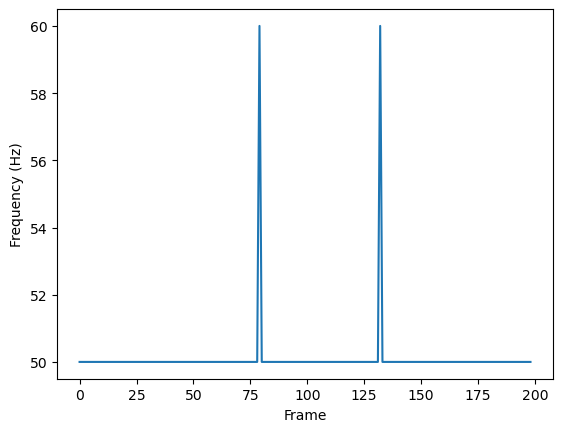

In [16]:
with open(ENFIFY_DIR/"config_nature.yml", "r") as f:
    config = yaml.safe_load(f)
file = INTERIM_DATA_DIR / "Carioca1/HC01-00-tamp.wav"

sample_freq, sig = wavfile.read(file)
features = freq_feature_pipeline(sig, sample_freq, config)

# plot frequency time series
time = np.arange(len(features)) * config["frame_overlap"] * config["frame_len"] / 1000
plt.plot(features)
plt.xlabel("Frame")
plt.ylabel("Frequency (Hz)")
plt.show()